In [6]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib.ticker import IndexLocator
import time, sys
import pickle
import torch
import torch.nn as nn

In [7]:
# Given parameters
nx = 60
ny = 60
tf = 1.0
dt = 2.0e-3
nt = int(tf/dt)
xmin = 0; xmax = 1
ymin = 0; ymax = 1
dims = (ny,nx)

# latent space dim.
f_list=np.array([3,4,5,6])
print('Latent Sapce Dim. {}'.format(f_list))

# parameters
p_inter=5
FOM_parameters = np.arange(75,125+1,1,dtype=int)
print("Prediction Parameters: {}".format(FOM_parameters))
print("training parameters={}".format(FOM_parameters[p_inter:-p_inter:p_inter]))

# generate mesh grid
[xv,yv]=np.meshgrid(np.linspace(xmin,xmax,nx),np.linspace(ymin,ymax,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

# file path
file_path_gappy_DEIM_result = "../__result/ex16_diffusion/ex16_AE_swish_gappy_inner_DEIM_result_seed_{}.p".format(seed)
print(file_path_gappy_DEIM_result)

# Gauss-Newton params
maxitr=4
tol=1e-8

# full, inner, bc index
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
x0_multi_index=(multi_index_j[:,0].flatten(),multi_index_i[:,0].flatten())
x1_multi_index=(multi_index_j[:,-1].flatten(),multi_index_i[:,-1].flatten())
y0_multi_index=(multi_index_j[0,:].flatten(),multi_index_i[0,:].flatten())
y1_multi_index=(multi_index_j[-1,:].flatten(),multi_index_i[-1,:].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
bc_raveled_indicies=np.unique(np.concatenate((x0_raveled_indicies,x1_raveled_indicies,
                                              y0_raveled_indicies,y1_raveled_indicies)))
inner_raveled_indicies=np.setdiff1d(full_raveled_indicies,bc_raveled_indicies)

Latent Sapce Dim. [3 4 5 6]
Prediction Parameters: [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
training parameters=[ 80  85  90  95 100 105 110 115 120]
../__result/ex16_diffusion/ex16_AE_swish_gappy_inner_DEIM_result_seed_5.p


In [8]:
def DEIM(phi_f, nfeval, unseen=np.array([])):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    
    l=0
    u=np.reshape(phi_f[:,l],(n,1))
    r=np.abs(u)
    if len(unseen) >0 :
        r[unseen]=ninf
    p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
    p=p_temp
    U=u
    
    ns=int(np.ceil((nfeval-1)/(m-1)))
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        for k in range(ns):
            if len(p)==nfeval:
                return p
            c=np.linalg.lstsq(U[p,:],u[p,:],rcond=None)[0]
            r=np.abs(u-U@c)
            r[p]=ninf
            if len(unseen) > 0:
                r[unseen]=ninf
            p_temp=np.argsort(-r,axis=0,kind='stable')[:1][0]
            p=np.sort(np.append(p,p_temp))
        U=np.concatenate((U,u),axis=1)
         
    return p

Latent Space Dimension: 3
# of measurments: 12
[  61   91  244 1018 1498 1899 3053 3110 3260 3356 3425 3538]
Latent Space Dimension: 4
# of measurments: 12
[  61  183  366  793 1862 2158 2451 2518 3236 3329 3506 3538]
Latent Space Dimension: 5
# of measurments: 12
[  61  244  672 1022 1678 2395 3147 3171 3235 3361 3394 3417]
Latent Space Dimension: 6
# of measurments: 12
[  61  243  548 1651 1742 1850 2275 3109 3293 3477 3519 3538]


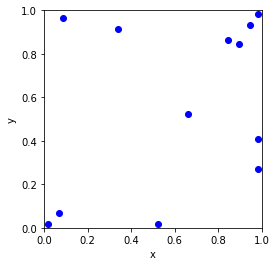

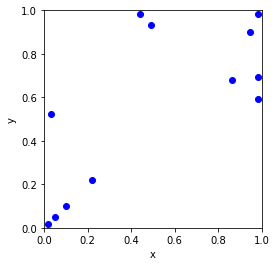

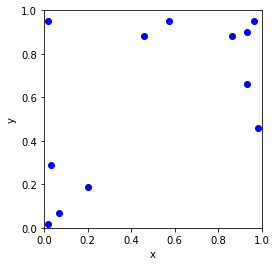

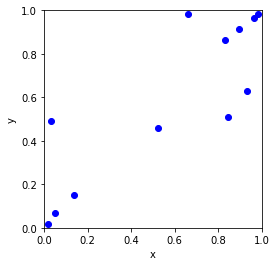

In [9]:
for ii in range(len(f_list)):
    f=f_list[ii]
    print("Latent Space Dimension: {}".format(f))
    
    # file path
    file_name_AE="../__model/ex16_diffusion/ex16_AE_{}_swish_seed_{}.p".format(f,seed)
    file_path_residual_SVD="../__model/ex16_diffusion/ex16_AE_{}_swish_residual_SVD_seed_{}.p".format(f,seed)
    
    with open(file=file_path_residual_SVD, mode='rb') as fff:
        SVD=pickle.load(fff)

     # DEIM
    num_msmt=12
    phi_r=SVD['U'][:,:num_msmt]
    msmt_idx=DEIM(phi_r,num_msmt,bc_raveled_indicies)
    msmt_idx.sort()

    # precompute
    ZTphi_r=phi_r[msmt_idx]
    ZTphi_r_pinv=np.linalg.pinv(ZTphi_r)
    phi_rZTphi_r_pinv=phi_r.dot(ZTphi_r_pinv)

    num_msmt=len(msmt_idx)
    print("# of measurments: {}".format(num_msmt))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(x[msmt_idx],y[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig("../__result/ex16_diffusion/ex16_AE_{}_swish_inner_DEIM_{}_samples_seed_{}.png".format(f,num_msmt,seed))

# gappyAE

Dim. of latent space is 3
# of measurments: 12
[  61   91  244 1018 1498 1899 3053 3110 3260 3356 3425 3538]


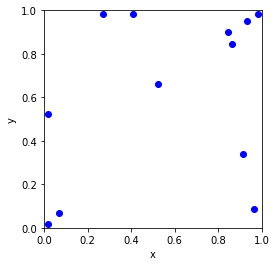

Param is 75
Time elapsed: 29.299766778945923 sec
average relative error of u: 0.197873409775446%
maximum relative error of u: 0.47335399053840793%

Param is 76
Time elapsed: 48.17161297798157 sec
average relative error of u: 0.15669255879821173%
maximum relative error of u: 0.4608129125553979%

Param is 77
Time elapsed: 84.88732481002808 sec
average relative error of u: 0.12359575410107229%
maximum relative error of u: 0.4534252583162714%

Param is 78
Time elapsed: 26.039320945739746 sec
average relative error of u: 0.09820036345962804%
maximum relative error of u: 0.44799687639791497%

Param is 79
Time elapsed: 32.655298471450806 sec
average relative error of u: 0.08017027444372066%
maximum relative error of u: 0.4424453918174723%

Param is 80
Time elapsed: 34.509896755218506 sec
average relative error of u: 0.06885319108230188%
maximum relative error of u: 0.43578201617549184%

Param is 81
Time elapsed: 37.999309062957764 sec
average relative error of u: 0.06291019285628827%
maximum 

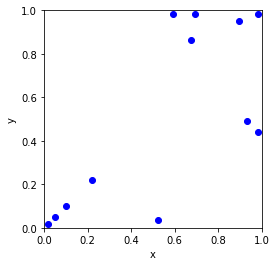

Param is 75
Time elapsed: 28.86575961112976 sec
average relative error of u: 0.24538928598146176%
maximum relative error of u: 0.6908827946523683%

Param is 76
Time elapsed: 32.1589412689209 sec
average relative error of u: 0.18394823806666427%
maximum relative error of u: 0.5742286048096357%

Param is 77
Time elapsed: 32.72843885421753 sec
average relative error of u: 0.13482794552682908%
maximum relative error of u: 0.48412404431823625%

Param is 78
Time elapsed: 32.59239149093628 sec
average relative error of u: 0.09801363232482749%
maximum relative error of u: 0.41972625452598433%

Param is 79
Time elapsed: 32.904680490493774 sec
average relative error of u: 0.07332244950688944%
maximum relative error of u: 0.3777645980390773%

Param is 80
Time elapsed: 33.41347527503967 sec
average relative error of u: 0.059710088825453825%
maximum relative error of u: 0.35292942077670963%

Param is 81
Time elapsed: 33.794076442718506 sec
average relative error of u: 0.05427272185566987%
maximum r

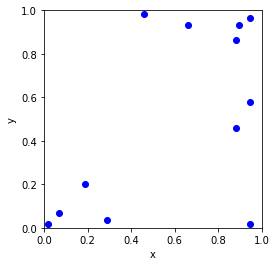

Param is 75
Time elapsed: 19.568633317947388 sec
average relative error of u: 0.22420041792008838%
maximum relative error of u: 0.5884509223565121%

Param is 76
Time elapsed: 20.659347772598267 sec
average relative error of u: 0.17375681953271327%
maximum relative error of u: 0.5292533300696042%

Param is 77
Time elapsed: 18.705865621566772 sec
average relative error of u: 0.134750138865452%
maximum relative error of u: 0.487254541645913%

Param is 78
Time elapsed: 18.00604510307312 sec
average relative error of u: 0.10674258530453608%
maximum relative error of u: 0.4588495287469583%

Param is 79
Time elapsed: 18.085955381393433 sec
average relative error of u: 0.08857581080564915%
maximum relative error of u: 0.44000693487292125%

Param is 80
Time elapsed: 18.407283782958984 sec
average relative error of u: 0.07802299273467152%
maximum relative error of u: 0.4270646746384044%

Param is 81
Time elapsed: 18.535367488861084 sec
average relative error of u: 0.07221412543016484%
maximum re

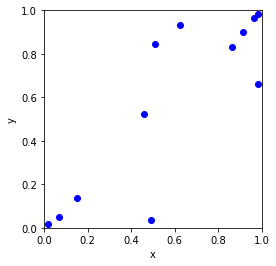

Param is 75
Time elapsed: 17.08923077583313 sec
average relative error of u: 0.2286783987216415%
maximum relative error of u: 0.8223855725453035%

Param is 76
Time elapsed: 16.543811559677124 sec
average relative error of u: 0.1757352457839029%
maximum relative error of u: 0.7041533406641398%

Param is 77
Time elapsed: 16.27208948135376 sec
average relative error of u: 0.13244985287282496%
maximum relative error of u: 0.6132002738643033%

Param is 78
Time elapsed: 17.493295907974243 sec
average relative error of u: 0.09910313847437267%
maximum relative error of u: 0.5490524643571405%

Param is 79
Time elapsed: 17.18111562728882 sec
average relative error of u: 0.07607168525057234%
maximum relative error of u: 0.5056519602141387%

Param is 80
Time elapsed: 17.37295413017273 sec
average relative error of u: 0.06290941429683003%
maximum relative error of u: 0.47436570821023727%

Param is 81
Time elapsed: 18.09198021888733 sec
average relative error of u: 0.05732154232388637%
maximum relat

In [10]:
solution=np.zeros((len(f_list),len(FOM_parameters),nt+1,nx*ny))
reduced=np.zeros((len(f_list),len(FOM_parameters),nt+1,f_list[-1]))
avg_rel_err=np.zeros((len(f_list),len(FOM_parameters)))
rel_err=np.zeros((len(f_list),len(FOM_parameters),nt+1))
elapsed_time=np.zeros((len(f_list),len(FOM_parameters)))

for ii in range(len(f_list)):
    f=f_list[ii]
    print("Dim. of latent space is {}".format(f))
    
    # file path
    file_name_AE="../__model/ex16_diffusion/ex16_AE_{}_swish_seed_{}.p".format(f,seed)
    file_path_residual_SVD="../__model/ex16_diffusion/ex16_AE_{}_swish_residual_SVD_seed_{}.p".format(f,seed)
    
    with open(file=file_path_residual_SVD, mode='rb') as fff:
        SVD=pickle.load(fff)

     # DEIM
    num_msmt=12
    phi_r=SVD['U'][:,:num_msmt]
    msmt_idx=DEIM(phi_r,num_msmt,bc_raveled_indicies)
    msmt_idx.sort()

    # precompute
    ZTphi_r=phi_r[msmt_idx]
    ZTphi_r_pinv=np.linalg.pinv(ZTphi_r)
    phi_rZTphi_r_pinv=phi_r.dot(ZTphi_r_pinv)

    num_msmt=len(msmt_idx)
    print("# of measurments: {}".format(len(msmt_idx)))
    print(msmt_idx)

    # plot measuremnt positions
    plt.figure()
    plt.scatter(y[msmt_idx],x[msmt_idx], color = 'blue')
    plt.axis('square')
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
        
    with open(file=file_name_AE, mode='rb') as ff:    
        AE = pickle.load(ff)

    en_wu1=AE['en_wu1']
    en_bu1=AE['en_bu1']
    en_wu2=AE['en_wu2']
    de_wu1=AE['de_wu1']
    de_bu1=AE['de_bu1']
    de_wu2=AE['de_wu2']
    de_wu1T=AE['de_wu1T']
    de_wu2T=AE['de_wu2T']
    de_wu2_sp=AE['de_wu2_sp']
    de_wu2T_sp=AE['de_wu2T_sp']
    u_ref=AE['u_ref']

    latent_dim=de_wu1.shape[1]
    
    # numpy version of AE
    def sigmoid_np(input):
        return (1.0/(1.0+np.exp(-input))).astype('float32')

    def encoder_u_np_forward(x):
        z1 = en_wu1.dot(x) + en_bu1
        a1 = z1 * sigmoid_np(z1)
        y = en_wu2.dot(a1)   
        return y

    def decoder_u_np_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = de_wu2.dot(a1)  
        return y

    def decoder_u_sp_forward(x):
        z1 = de_wu1.dot(x) + de_bu1
        a1 = z1 * sigmoid_np(z1)
        y = sp.csr_matrix.dot(de_wu2_sp,a1)
        return y

    def decoder_u_np_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = de_wu2.dot(a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = dout.dot(de_wu2T)   
        return y,dydxT

    def decoder_u_sp_forward_backwardT(x):
        z1 = de_wu1.dot(x) + de_bu1
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = sp.csr_matrix.dot(de_wu2_sp,a1)

        dout = de_wu1T
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
        return y,dydxT
    
    m,M2=de_wu2.shape

    class Decoder_U_FC(nn.Module):

        def __init__(self,):
            super(Decoder_U_FC, self).__init__()
            self.fc1 = nn.Linear(latent_dim,M2)
            self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
            self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
    #         self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
    #         self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))

            self.fc2 = nn.Linear(M2,m,bias=False)
            self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
    #         self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))

        def forward(self, x):
            x = self.fc1(x)
            x = self.fc2(x)
            return x

    model = Decoder_U_FC()

    x_in=torch.ones(latent_dim)
    y_out=model(x_in)

    p_hr=msmt_idx

    upstream=torch.zeros_like(y_out)
    upstream[p_hr]=1.0

    y_out.backward(upstream)

    # masks for subnet
    wu1_mask=model.fc1.weight.grad
    wu2_mask=model.fc2.weight.grad

    bu1_mask=model.fc1.bias.grad

    # subnet sparse weight
    idx1=wu1_mask.to_sparse()._indices()
    i1=idx1.numpy()[0]
    j1=idx1.numpy()[1]
    v1=de_wu1[i1,j1]
    wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

    idx2=wu2_mask.to_sparse()._indices()
    i2=idx2.numpy()[0]
    j2=idx2.numpy()[1]
    v2=de_wu2[i2,j2]
    wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

    # subnet compressed weight
    i1,j1,v1=sp.find(wu1_sb_sp)
    i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
    i1_comp=np.arange(i1_unique.size)
    i1_comp=i1_comp[i1_inverse]
    j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
    j1_comp=np.arange(j1_unique.size)
    j1_comp=j1_comp[j1_inverse]
    wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

    i2,j2,v2=sp.find(wu2_sb_sp)
    i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
    i2_comp=np.arange(i2_unique.size)
    i2_comp=i2_comp[i2_inverse]
    j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
    j2_comp=np.arange(j2_unique.size)
    j2_comp=j2_comp[j2_inverse]
    wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

    wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
    wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
    wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

    wu1_sb_comp_denseT=wu1_sb_comp_dense.T
    wu2_sb_comp_denseT=wu2_sb_comp_dense.T

    # subnet compressed bias
    bu1_sb_comp_dense=de_bu1[i1_unique]
    bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

    # Using sparse matrix
    wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
    wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

    def decoder_u_sb_np_forward(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = z1 * sigmoid_np(z1)
        y = wu2_sb_comp_dense.dot(a1)  
        return y

    def decoder_u_sb_np_forward_backwardT(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = wu2_sb_comp_dense.dot(a1) 

        dout = wu1_sb_comp_denseT
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = dout.dot(wu2_sb_comp_denseT)
        return y,dydxT

    def decoder_u_sb_sp_forward(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        a1 = z1 * sigmoid_np(z1)
        y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
        return y

    def decoder_u_sb_sp_forward_backwardT(x):
        z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
        sigma = sigmoid_np(z1)
        a1 = z1 * sigma
        y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

        dout = wu1_sb_comp_denseT
        dout = (sigma+a1*(1-sigma))*dout
        dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
        return y,dydxT

    for jj in range(len(FOM_parameters)):
        FOM_parameter=FOM_parameters[jj]
        print("Param is {}".format(FOM_parameter))
        
        # Load FOM solution
        ex = np.load('../__data/ex16_diffusion/ex16_interp_{}.npz'.format(FOM_parameter), allow_pickle = True)
        ex = ex.f.arr_0
        u_full = ex.reshape(nt+1,-1).astype('float32')

        # take measurments
        um = u_full[:,msmt_idx]

        # Initial condition
        u0=u_full[0]
        u_hat0=encoder_u_np_forward(u0.astype('float32')-u_ref)

        # gappyAE
        t_start_gappyAE=time.time()

        # solution
        u_reduced=np.zeros((nt+1,latent_dim))
        u_gappyAE=np.zeros((nt+1,ny*nx))

        # IC
        u_reduced[0]=np.copy(u_hat0)
        u_gappyAE[0]=np.copy(u0)

        for k in range(nt):
#             print("")
#             print(k,"th time step:")

            u_hatw=np.copy(u_reduced[k])

            umw,Jg_umT=decoder_u_sb_sp_forward_backwardT(u_hatw)

            umw += u_ref[msmt_idx]

            J_r=-Jg_umT.T
            J_pinv=np.linalg.pinv(ZTphi_r_pinv.dot(J_r)).dot(ZTphi_r_pinv)

            r_um_hat = um[k+1]-umw

            res = np.linalg.norm(J_pinv.dot(r_um_hat))
#             res = np.linalg.norm(r_um_hat)
            res_hist=[res]
            for itr in range(maxitr):
                du_hatw = J_pinv.dot(r_um_hat)

                u_hatw -= du_hatw

                umw,Jg_umT=decoder_u_sb_sp_forward_backwardT(u_hatw)

                umw += u_ref[msmt_idx]

                J_r=-Jg_umT.T
                J_pinv=np.linalg.pinv(ZTphi_r_pinv.dot(J_r)).dot(ZTphi_r_pinv)

                r_um_hat = um[k+1]-umw

                res = np.linalg.norm(J_pinv.dot(r_um_hat))
#                 res = np.linalg.norm(r_um_hat)
                res_hist.append(res)
#                 print(itr,"th Newton iteration", "res:", "{:.8e}".format(res))

                if res<tol:
                    break

            u_reduced[k+1]=u_hatw.copy()
            u_gappyAE[k+1]=u_ref+decoder_u_sp_forward(u_reduced[k+1])

        # elapsed time    
        t_elapsed_gappyAE=time.time()-t_start_gappyAE
        print('Time elapsed: {} sec'.format(t_elapsed_gappyAE))

        # error
        u_rel_err_gappyAE=np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)\
                         /np.linalg.norm(u_full,ord=2,axis=1)*100
        u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)**2))\
                     /np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
        print("average relative error of u: {}%".format(u_avg_rel_err))
        print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyAE)))
        print()

        # save result
        solution[ii,jj]=u_gappyAE
        reduced[ii,jj,:,:f]=u_reduced
        avg_rel_err[ii,jj]=u_avg_rel_err
        rel_err[ii,jj]=u_rel_err_gappyAE
        elapsed_time[ii,jj]=t_elapsed_gappyAE
    
results={'solution':solution,'reduced':reduced,'avg_rel_err':avg_rel_err,'rel_err':rel_err,'elapsed_time':elapsed_time}
with open(file=file_path_gappy_DEIM_result, mode='wb') as ff:
    pickle.dump(results, ff)

Text(0.5, 1.0, 'Max. Rel. Err. vs Parameters')

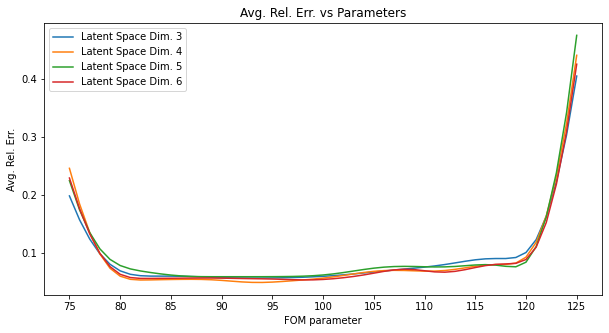

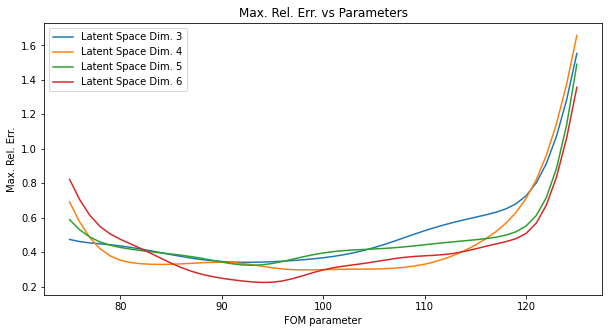

In [11]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

idx=[0,1,2,3]

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:  
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['avg_rel_err'][i][p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])

ax=plt.gca()
ax.xaxis.set_major_locator(IndexLocator(p_inter,0))
ax.xaxis.set_minor_locator(IndexLocator(p_inter,p_inter))
ax.tick_params(axis='x',which='minor',labelcolor='blue',labelsize=20)
plt.title('Avg. Rel. Err. vs Parameters')
# plt.savefig("../__result/ex16_diffusion/ex16_AE_inner_DEIM_avg_rel_err_seed_{}.png".format(seed))

# figure rel.err vs data points
plt.figure(figsize=(10,5)) 
for i in idx:  
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['rel_err'][i].max(axis=1)[p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])
plt.title('Max. Rel. Err. vs Parameters')
# plt.savefig("../__result/ex16_diffusion/ex16_AE_inner_DEIM_max_rel_err_seed_{}.png".format(seed))

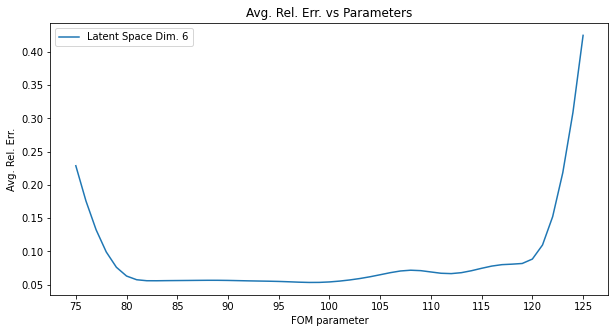

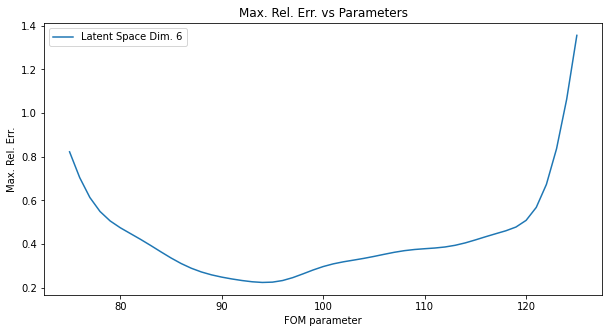

In [12]:
# with open(file=file_path_gappy_DEIM_result, mode='rb') as ff:
#     results=pickle.load(ff)    

idx = [3]

# figure avg.rel.err vs params
plt.figure(figsize=(10,5))
for i in idx:  
    plt.plot(FOM_parameters,results['avg_rel_err'][i])
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['avg_rel_err'][i][p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Avg. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])

ax=plt.gca()
ax.xaxis.set_major_locator(IndexLocator(p_inter,0))
ax.xaxis.set_minor_locator(IndexLocator(p_inter,p_inter))
ax.tick_params(axis='x',which='minor',labelcolor='blue',labelsize=20)
plt.title('Avg. Rel. Err. vs Parameters')
plt.show()

# figure rel.err vs data points
plt.figure(figsize=(10,5)) 
for i in idx:  
    plt.plot(FOM_parameters,results['rel_err'][i].max(axis=1))
#     plt.scatter(FOM_parameters[p_inter:-p_inter:p_inter],results['rel_err'][i].max(axis=1)[p_inter:-p_inter:p_inter], color = 'blue')
plt.xlabel('FOM parameter')
plt.ylabel('Max. Rel. Err.')
plt.legend(["Latent Space Dim. "+str(f) for f in f_list[idx]])
plt.title('Max. Rel. Err. vs Parameters')
plt.show()

In [13]:
print(f_list)
print(FOM_parameters)

[3 4 5 6]
[ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]


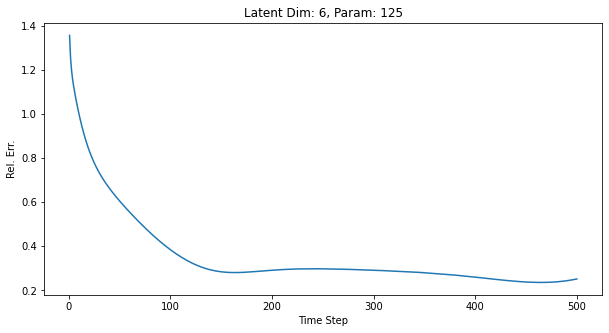

average relative error of u: 0.42469606696071244%

maximum relative error of u: 1.356188929283431%


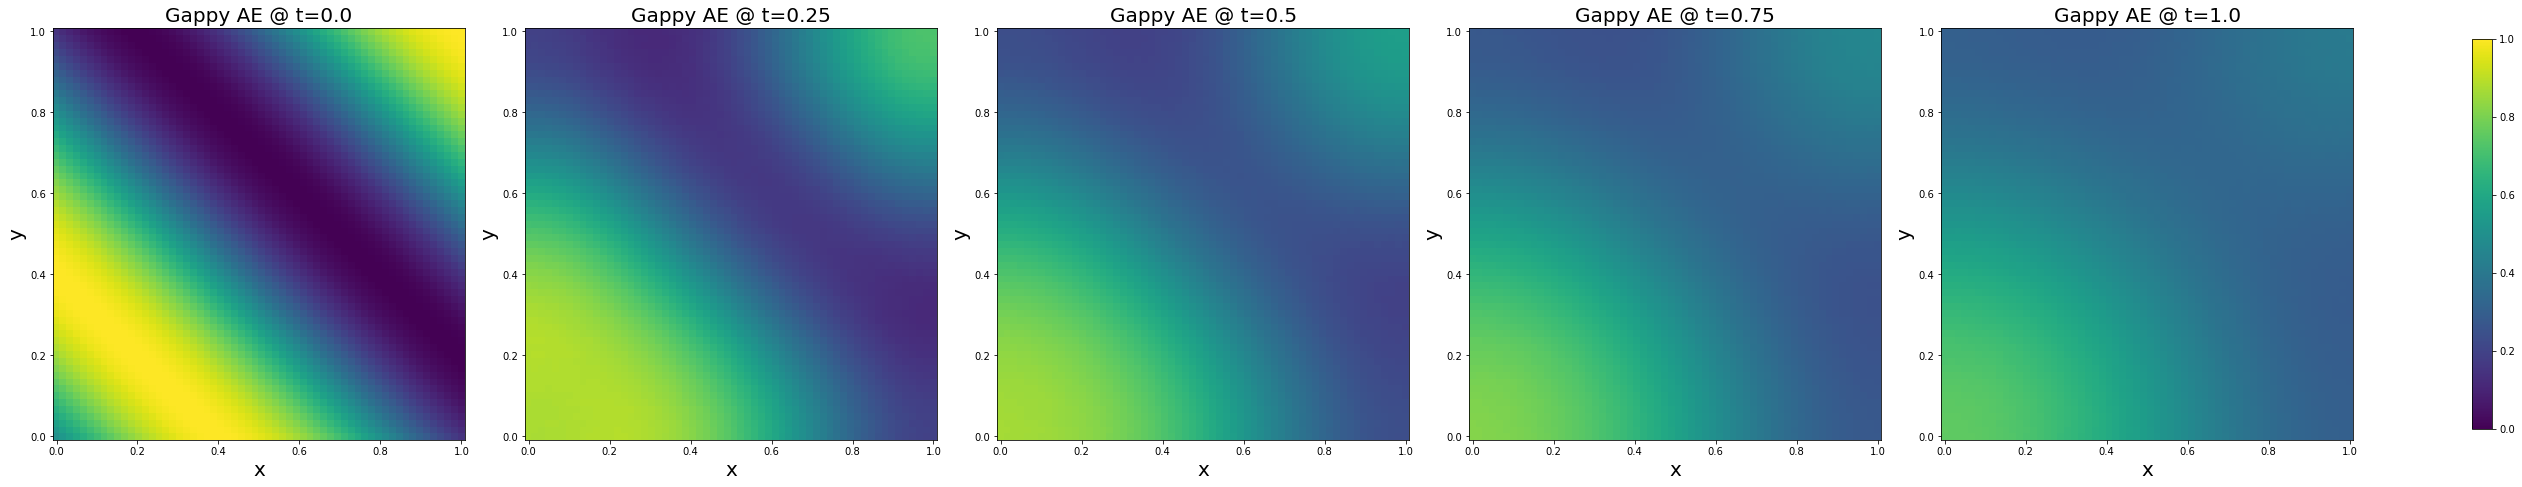

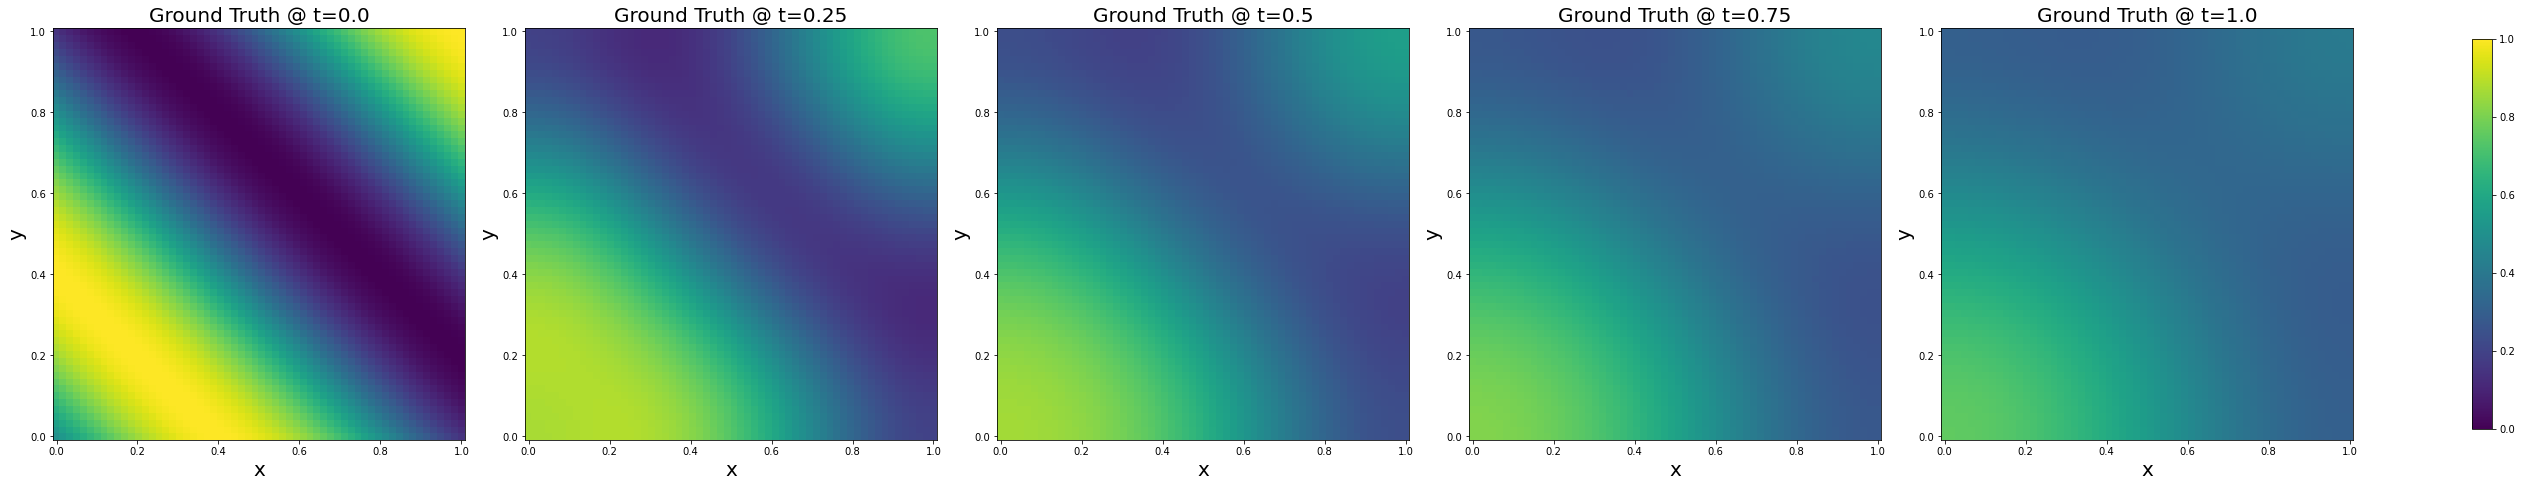

In [14]:
# figure rel.err vs at given param and POD basis
i=3; j=-1        
f=f_list[i]
param=FOM_parameters[j]

u_gappyAE=results['solution'][i,j]

ex = np.load('../__data/ex16_diffusion/ex16_interp_{}.npz'.format(param), allow_pickle = True)
ex = ex.f.arr_0
u_full = ex.reshape(nt+1,-1)

plt.figure(figsize=(10,5))
plt.plot(np.arange(1,nt+1),results['rel_err'][i,j,1:].flatten())
plt.xlabel('Time Step')
plt.ylabel('Rel. Err.')
plt.title("Latent Dim: {}, Param: {}".format(f,param))
plt.show()

# error
u_rel_err_gappyAE=np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)\
                 /np.linalg.norm(u_full,ord=2,axis=1)*100
u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_gappyAE,ord=2,axis=1)**2))\
             /np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
print("average relative error of u: {}%".format(u_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err_gappyAE)))
    
# plot original data
vmin=0; vmax=1
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_gappyAE[int(nt/4)*i].reshape(ny,nx),vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Gappy AE @ t={}'.format(int(nt/4)*i*dt),fontsize=20)

fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("../__result/ex16_diffusion/ex16_AE_{}_inner_DEIM_SOL_seed_{}.png".format(f,seed))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,7),layout='constrained')
for i in range(len(axes)):
    ax=axes[i]
    pcm = ax.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), u_full[int(nt/4)*i].reshape(ny,nx),vmin=vmin,vmax=vmax)
    ax.axis('square')
    ax.set_xlabel('x',fontsize=20)
    ax.set_ylabel('y',fontsize=20)
    ax.set_title('Ground Truth @ t={}'.format(int(nt/4)*i*dt),fontsize=20)

fig.colorbar(pcm, ax=axes.tolist(),shrink=0.8)
# plt.savefig("../__result/ex16_diffusion/ex16_ground_truth.png")

f=6
param=125


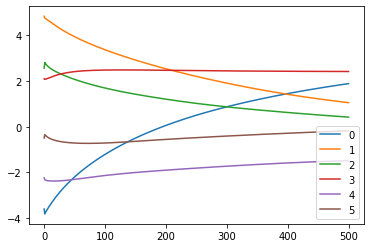

In [15]:
i=3; j=-1
f=f_list[i]; param=FOM_parameters[j]
print("f={}".format(f))
print("param={}".format(param))
plt.plot(results['reduced'][i,j][:,:f])
plt.legend(np.arange(f))
plt.show()